# 卷积神经网络
>卷积神经网络是一类强大的,为处理图像数据而设计的神经网络,基于卷积神经网络的模型在计算机视觉领域已经占主导地位,当今几乎所有的图像识别,目标检测或语义分割相关的学术竞赛和商业应用都以这种方法为基础
>卷积神经网络的设计得益于生物学,群论和一系列的补充实验,卷积神经网络需要的参数少于全连接架构的网络,而且卷积也很容易用GPU进行计算,因此卷积神经网络除了能够高效地采样从而获得精确的模型,还能够高效地计算.
## 从全连接层到卷积
>多层感知机非常适合处理表格数据,对于高维感知数据,这种缺少结构的网络可能会变得不实用
>如今人类和机器都能很好地区分猫和狗,因为图像中本就拥有丰富的结构,这些结构可以被人类和机器学习模型使用,卷积神经网络时机器学习利用自然图像中一些已知结构的创造性方法
### 不变性
>常识:猪通常不会在天上飞,飞机通常不会在水里游泳
>卷积神经网络将空间不变性的这一概念系统化,从而基于这个模型使用较少的参数来学习有用的表示
> 1.平移不变性:不管检测对象出现在图像中的哪个位置,神经网络的前面几层应该对相同的图像区域具有相似的反应,即为平移不变性
> 2.局部性(locality):神经网络的前面几层应该只探索输入图像中的局部区域,而不过度在意图像中相隔较远区域的关系,这就是局部性原则,最终可以聚合这些局部特征,以在整个图像级别进行预测
### 多层感知机的限制
>多层感知机的输入是二维图像X

>像素点之间互相影响,周围的像素点加起来求平均,平滑卷积操作,让周围的像素点和自己相差不大
>* 图像的平移不变性使我们以相同的方式处理局部图像,而不在乎它的位置
>* 局部性意味着计算相应的印象表示只需一小部分局部图像像素
>* 在图像处理中,卷积层通常比全连接层需要更少的参数,但依旧获得高效用的模型
>* 卷积神经网络是一类特殊的神经网络,它可以包含多个卷积层
>* 多个输入和输出通道使模型在每个空间位置可以获取图像的多方面特征

### 互相关运算
>严格来说卷积层是个错误的叫法,因为它表达的运算其实是互相关运算,而不是卷积运算,在卷积层中,输入张量和核张量通过互相关运算产生输出张量


In [5]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X,K):
    """计算二维互相关运算"""
    h,w=K.shape
    Y=torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y

X=torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K=torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

>卷积层对输入和卷积核权重进行互相关运算,并在添加标量偏置之后产生输出,所以卷积层中的两个被训练的参数是卷积核权重和标量偏置,在训练卷积层的模型时,我们也随机初始化卷积核权重

In [14]:
#实现二维卷积层
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        '''kernel_size是卷积核的大小'''
        super().__init__()
        self.weight=nn.Parameter(torch.rand(kernel_size))
        self.bias=nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias

In [15]:
#图像中目标的边缘检测
#通过找到像素变化的位置,来检测图像中不同颜色的边缘,首先构造一个6*8像素的黑白图像
X=torch.ones((6,8))
X[:,2:6]=0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [18]:
#构造一个高度为1,宽度为2的卷积核K,当进行互相关运算时,如果水平相邻的两元素相同,则输出为0,否则输出为非零
K=torch.tensor([[1.0,-1.0]])
#执行互相关运算
Y=corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [20]:
#将输入的二维图像转置,在加上如上的二维运算
corr2d(X.t(),K)
#可以看出之前检测到的垂直边缘消失了,这个卷积核K只能检测垂直边缘,无法检测水平边缘
#将K也转置一下,这样的话就可以检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

# 学习卷积核
>如果我们只需要寻找黑白边缘,那么[1,-1]的边缘检测器足以,然而当有了更复杂数值的卷积核,或者连续的卷积层,我们不可能手动的设置滤波器,那么我们是否可以学习由X生成Y的卷积核呢?
>首先我们构造一个卷积层,并将其卷积核初始化为随机张量,在接下来的每次迭代中,我们比较,Y与卷积层输出的平方误差,然后计算梯度来更新卷积核

In [43]:
#构造一个二维卷积层,它具有1个输出通道和形状为(1,2)的卷积核
conv2d=nn.Conv2d(1,1,kernel_size=(1,2),bias=False)

#这个二维卷积层使用思维输入和输出格式(批量大小,通道,高度,宽度)
#其中批量大小和通道数都为1
X=X.reshape((1,1,6,8))
Y=Y.reshape((1,1,6,7))
lr=3e-3  #学习率

for i in range(100):
    Y_hat=conv2d(X) #这里会进行前向传播
    l=(Y_hat-Y)**2 #计算平方误差损失
    conv2d.zero_grad() #反向传播之前将梯度清零
    l.sum().backward() #计算损失相对于卷积层的梯度
    #迭代卷积核
    conv2d.weight.data[:]-=lr*conv2d.weight.grad #更新卷积核的权重, 减去学习率*梯度
    if(i+1)%2==0:
        print(f'epoch{i+1},loss {l.sum():.3f}')

epoch2,loss 11.823
epoch4,loss 10.209
epoch6,loss 8.815
epoch8,loss 7.613
epoch10,loss 6.574
epoch12,loss 5.677
epoch14,loss 4.903
epoch16,loss 4.234
epoch18,loss 3.656
epoch20,loss 3.158
epoch22,loss 2.727
epoch24,loss 2.355
epoch26,loss 2.034
epoch28,loss 1.756
epoch30,loss 1.517
epoch32,loss 1.310
epoch34,loss 1.131
epoch36,loss 0.977
epoch38,loss 0.844
epoch40,loss 0.729
epoch42,loss 0.629
epoch44,loss 0.543
epoch46,loss 0.469
epoch48,loss 0.405
epoch50,loss 0.350
epoch52,loss 0.302
epoch54,loss 0.261
epoch56,loss 0.225
epoch58,loss 0.195
epoch60,loss 0.168
epoch62,loss 0.145
epoch64,loss 0.125
epoch66,loss 0.108
epoch68,loss 0.093
epoch70,loss 0.081
epoch72,loss 0.070
epoch74,loss 0.060
epoch76,loss 0.052
epoch78,loss 0.045
epoch80,loss 0.039
epoch82,loss 0.033
epoch84,loss 0.029
epoch86,loss 0.025
epoch88,loss 0.022
epoch90,loss 0.019
epoch92,loss 0.016
epoch94,loss 0.014
epoch96,loss 0.012
epoch98,loss 0.010
epoch100,loss 0.009


In [44]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9737, -0.9737]])

### 互相关和卷积
>由于卷积核是从数据中学习到的,因此无论这些层执行严格的卷积运算还是互相关运算,卷积层的输出都不会受到影响,当卷积层执行严格的卷积运算时,将得到与互相关运算相同的输出
>卷积层有时被称为特征映射(feature map),因为它可以被视为一个输入映射到下一层的空间维度的转换器,在卷积神经网络中,对于某一层的任意元素x,其感受野(receptive field)是指在前向传播期间可能影响x计算的所有元素(来自所有先前层)
>感受野可能大于输入的实际大小
### 小结
>* 二维卷积层的核心计算是二维互相关运算,最简单的形式是,对二维输入数据和卷积核执行互相关操作,然后添加一个偏置
>* 我们可以设计一个卷积核来检测图像的边缘
>* 我们可以从数据中学习卷积核的参数
>* 学习卷积核时,无论用严格卷积运算或互相关运算,卷积层的输出不会受太大影响
>* 当需要检测输入特征中更广阔的区域时,我们可以构建一个更深的卷积网络

### 填充和步幅
>在应用多层卷积时,由于我们通常使用小卷积核,因此对于任何单个卷积,我们可能只会丢失几个像素,但随着我们连续卷积层,累积丢失的像素就多了
>通常我们添加ph行填充(一半在顶部,一半在底部),pw列填充(左侧一半,右侧一半),输出的高度和宽度分别增加ph和pw
>多数情况下,ph=kh-1,pw=kw-1,使得输入和输出具有相同的宽度,这样可以在构建网络的时候更容易地预测每个图层的输出形状,卷积神经网络中卷积核的高度和宽度通常是奇数,选择奇数的好处是:保持空间维度的同时,我们可以在顶部和底部填充相同数量的行,左侧和右侧填充相同数量的列

In [1]:
import torch
from torch import nn


#为了方便,我们定义了一个计算卷积层的参数
#此函数初始化卷积层权重,并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d,X):
    #将输入张量调整为卷积层能处理的样子
    X=X.reshape((1,1)+X.shape)#这里的(1,1)表示批量大小和通道数都是1
    Y=conv2d(X)
    #省略前两个维度:批量大小和通道
    return Y.reshape(Y.shape[2:])

#请注意,这里每边都填充了1行或1列,因此总共添加了2行或2列
conv2d=nn.Conv2d(1,1,kernel_size=3,padding=1)#生成一个卷积层
X=torch.rand(size=(8,8))#创建一个张量
comp_conv2d(conv2d,X).shape#输出形状

torch.Size([8, 8])

In [2]:
#当卷积核的宽度和高度不同时,我们可以填充不同的高度和宽度,使输出和输入具有相同的高度和宽度
#高度为5,宽度为3的卷积核,高度和宽度的两边的填充分别为2和1
conv2d=nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape


torch.Size([8, 8])

>垂直步幅为sh,水平步幅为sw,当ph=kh-1,pw=kw-1,输出形状为(nh/sh)*(nw/sw)

In [3]:
#将高度和宽度的步幅设置为2,从而将输入的高度和宽度减半
conv2d=nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [4]:
#
conv2d=nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

### 小结
>* 填充可以增加输出的宽度和高度,这常用来使输出和输入具有相同的高和宽
>* 步幅可以减少输出的高和宽
>* 填充和步幅可以用于有效地调整数据的维度


### 多输入多输出通道
>当输入包含多个通道时,需要构造一个与输入数据具有相同输入通道数的卷积核,以便与输入数据进行互相关运算,假设输入的通道数为ci,那么卷积核的输入通道也为ci,如果卷积核的窗口形状为kh*kw,那么当ci=1时,我们可以把卷积核看作形状为kh*kw的二维张量
>每一个输出通道用来识别一个模式`
>1*1卷积层,不识别空间模式,只是融合通道,其实就是一个全连接层

In [8]:
import torch
from d2l import torch as d2l


def corr2d_multi_in(X,K):
    #先遍历X和K的第0个维度,再把他们加在一起
    return sum(d2l.corr2d(x,k)for x,k in zip(X,K))

In [24]:
X = torch.tensor([[[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]],
                  [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]])
K = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[1.0,2.0],[3.0,4.0]]])
print(corr2d_multi_in(X,K))

tensor([[ 56.,  72.],
        [104., 120.]])


In [25]:
#实现一个计算多个通道的输出的互相关函数
def corr2d_multi_in_out(X,K):
    #迭代K的第0个维度,每次都对X执行互相关运算
    #最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X,k)for k in K],0)#从第0维运算,每次都执行互相关运算,最后把结果叠加到一起


In [26]:
print(K.shape)
K=torch.stack((K,K+1,K+2),0)
K.shape

torch.Size([2, 2, 2])


torch.Size([3, 2, 2, 2])

In [27]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [30]:
#使用全连接层实现1*1卷积
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w=X.shape
    c_o=K.shape[0]
    X=X.reshape((c_i,h*w))
    K=K.reshape((c_o,c_i))
    #全连接层中的矩阵乘法
    Y=torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [31]:
#当执行1x1卷积运算时,上述函数相当于先前实现的互相关函数corr2d_multi_in_out
X=torch.normal(0,1,(3,3,3))
K=torch.normal(0,1,(2,3,1,1))

In [33]:
Y1=corr2d_multi_in_out_1x1(X,K)
Y2=corr2d_multi_in_out(X,K)
assert float(torch.abs(Y1-Y2).sum())<1e-6

### 汇聚层
>通常当我们处理图像时,我们希望逐渐降低隐藏表示的空间分辨率,聚集信息,这样随着我们在神经网络中层叠的上升,每个神经元对其敏感的感受野就越大.
>我们的机器学习任务通常会跟全局图像的问题有关(例如,图像是否包含一只猫呢?),所以我们最后一层的神经元应该对整个输入的全局敏感.通过逐渐聚合信息,生成越来越粗糙的映射,最终实现学习全局表示的目标,同时将卷积图层的优势保留在中间层
>使用2x2最大汇聚层,即使在高度和宽度上移动一个元素,卷积层仍然可以识别到模式

In [ ]:
#实现汇聚层的前向传播,
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X,pool_size,mode='max'):
    p_h,p_w=pool_size
    Y=torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=='max':
                Y[i,j]=X[i:i+p_h,j:j+p_w].max()
            elif mode=='avg':
                Y[i,j]=X[i:i+p_h,j:j+p_w].mean()
    return Y


X=torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
pool2d(X,(2,2))

### 卷积神经网络(LeNet)
>利用卷积层代替全连接层的另一个好处是:模型更简洁,所需参数更少
>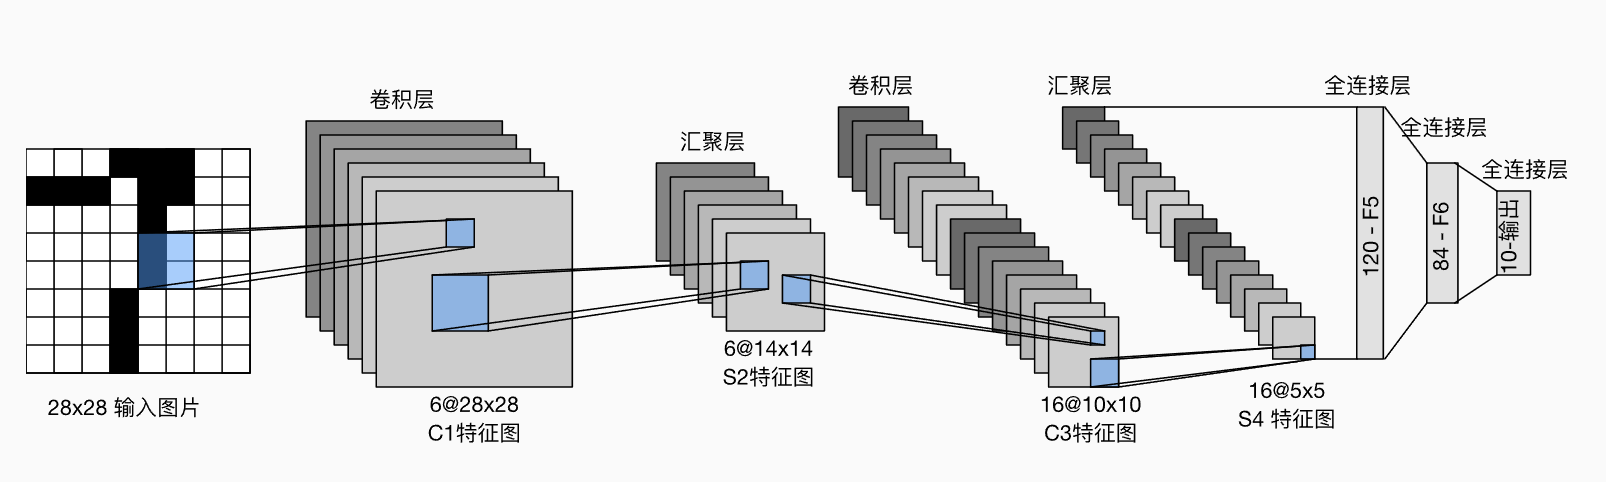
>每个卷积块中的基本单元是一个卷积层,一个sigmoid激活函数和平均汇聚层,每个卷积层使用5*5卷积核和一个sigmoid函数,这些层将输入映射到多个二维特征输出,通常同时增加通道的数量,第一卷积层有6个输出通道,第二个卷积层有16个输出通道,每个2*2池操作(步幅2)通过空间下采样将维数减少4倍,卷积的输出形状由批量大小,通道数,高度,宽度决定.
>为了将卷积块的输出传递给稠密块,我们必须在小批量中展平每个样本,换言之,我们将这个四维输入转换成全连接层所期望的二维输入,这里的二维表示的第一个维度索引小批量中的样本,第二个维度给出每个样本的平面向量表示,LeNet的稠密块有三个全连接层,分别有120,84,和10个输出,

In [1]:
import torch
from torch import nn 
from d2l import torch as d2l
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [2]:
X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


#### 模型训练
>LeNet在Fashion-MNIST数据集上的表现.

In [7]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

>虽然卷积神经网络的参数较少,但与深度的多层感知机相比,它们的计算成本仍然很高,因为每个参数都参与更多的乘法,通过使用GPU可以用它加快训练


In [8]:
def evaluate_accuracy_gpu(net,data_iter,device=None):#@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    #正确预测的数量,总预测的数量
    metric=d2l.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                #BERT微调所需的
                X=[x.to(device)for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [9]:
#训练

def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    """
    net:神经网络模型
    train_iter:训练数据迭代器
    test_iter:测试数据迭代器
    num_epochs:训练的轮数
    lr:学习率
    device:训练的设备
    """
    """用GPU训练模型"""
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    """
    定义一个内部函数init_weight用于初始化模型的权重
    使用Xavier初始化方法来初始化全连接层和卷积层的权重
    使用net.apply(init_weight)将权重初始化函数应用于子模型的所有子模块
    """
    print('training on',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train loss','train acc','test acc'])
    timer,num_batches=d2l.Timer(),len(train_iter)
    """
    打印训练设备
    将模型移动到指定设备上
    创建一个优化器(使用随机梯度下降SGD),并设置学习率
    定义损失函数为交叉熵损失
    创建一个动画器d2l.Animator用于实时绘制训练过程中的损失和准确率
    初始化一个计时器d2l.Timer和计算训练批次的数量
    """

    for epoch in range(num_epochs):#遍历每个epoch
        #训练损失之和,训练准确率之和,样本数
        metric=d2l.Accumulator(3)#创建一个累加器用于记录损失总和,准确率总和和样本总数
        net.train()#将模型设置为训练模式
        for i,(X,y) in enumerate(train_iter):#遍历训练数据集中的每个批次
            timer.start()#开始计时
            optimizer.zero_grad()#清零梯度
            X,y=X.to(device),y.to(device)#将输入X和标签y移动到设备上
            y_hat=net(X)#net(X)会进行前向传播
            l=loss(y_hat,y)#计算损失
            l.backward()#反向传播计算梯度
            optimizer.step()#更新模型参数
            with torch.no_grad():#禁用梯度计算,并记录当前批次的损失和准确率
                metric.add(1*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()#停止计时
            train_l=metric[0]/metric[2]#计算训练损失
            train_acc=metric[1]/metric[2]#计算准确率
            if(i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
        test_acc=evaluate_accuracy_gpu(net,test_iter)#计算当前epoch的测试准确率
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {train_l:.3f},train acc{train_acc:.3f},'f'test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec 'f'on{str(device)}')

loss 1.000,train acc0.830,test acc 0.817
9576.8 examples/sec oncpu


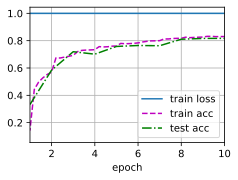

In [10]:
lr,num_epochs=0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

>d2l.accumulator:用于累加多个值
>d2l.accuracy:计算预测的准确率
>d2l.Animator:用于实时绘制训练过程中损失和准确率的变化
>evaluate_accuracy_gpu:用于在测试集上评估模型的准确率
>d2l.Timer:用于计时